# Code for fitting DATA = a*QCD + b*VBF
## Diego Baron

In [3]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

iminuit version: 2.10.0


In [6]:
# our line model, unicode parameter names are supported :)
def model(shape1,shape2, a, b):
    return a*shape1 + b*shape2


# generate random toy data with random offsets in y
np.random.seed(1)
x_axis = np.linspace(0, 1, 10)
shape1_yerr = 0.1  # could also be an array
shape2_yerr = 0.2  # could also be an array
y_axis = model(data_x, 0.9, 3)+ data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o");

TypeError: line() missing 1 required positional argument: 'b'

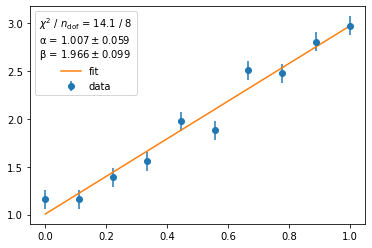

In [5]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, α=0, β=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info));